## AIM: Obtain patient-level predictions from best models

For the best models patient-level predictions will be obtained. These patient-level predictions will be determined by summing the propabilities of the epoch predictions and taking the highest probability class.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import joblib
import mne
import os
import matplotlib.pyplot as plt
import yaml
import random

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os

import optuna

import torch.nn as nn
from lightning.pytorch.loggers import CSVLogger
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
from torch.utils.data import Dataset, DataLoader, Subset
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

%matplotlib inline

## Functions

In [2]:
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)
    
# functions for loading the epoched EEG data
def get_filepath(epoch_dir, participant_ids):
    """
    Function to get the filepath of the epoched EEG recording
    :param epoch_dir: directory containing the epoched EEG recordings
    :param participant_ids: list of participant IDs to include
    """
    filepaths = []
    found_ids = set()
    
    for subdir, dirs, files in os.walk(epoch_dir):
        for file in files:
            for participant_id in participant_ids:
                if participant_id in file:
                    filepaths.append(os.path.join(subdir, file))
                    found_ids.add(participant_id)
    
    # Print participant IDs if no files matching those IDs are found
    for participant_id in participant_ids:
        if participant_id not in found_ids:
            print(f"No files found for participant ID {participant_id}")

    return filepaths

class EpochDataset(torch.utils.data.Dataset):
    def __init__(self, participant_ids, epoch_dir, df_classes, replication_set=False):
        self.filepaths = get_filepath(epoch_dir, participant_ids)
        self.replication_set = replication_set
        self.epochs = []
        self.participant_ids = []
        if not replication_set:
            self.diagnosis = []
        self.df_classes = df_classes
        self._load_data()
        if not replication_set:
            assert len(self.epochs) == len(self.participant_ids) == len(self.diagnosis)
        print(f"Loaded {len(self.epochs)} epochs")

    def _load_data(self):
        all_epochs = []
        for filepath in self.filepaths:
            epochs = torch.load(filepath, weights_only=False)
            # get participant ID from filepath to make sure the participant ID is correct
            participant_id = filepath.split("\\")[-1].split(".")[0]
            # print(f'{participant_id = }')
            # get the diagnosis of the participant
            if not self.replication_set:
                diagnosis = self.df_classes[self.df_classes["participants_ID"] == participant_id]["labels"].values[0]
                self.diagnosis.extend([diagnosis]*epochs.shape[0])

            all_epochs.append(epochs)
            self.participant_ids.extend([participant_id]*epochs.shape[0])

        self.epochs = np.concatenate(all_epochs, axis=0)

    def __len__(self):
        return self.epochs.shape[0]
    
    def __getitem__(self, idx):
        epoch = self.epochs[idx]
        participant_id = self.participant_ids[idx]
        if not self.replication_set:
            y = self.diagnosis[idx]
            return torch.tensor(epoch, dtype=torch.float32), y, participant_id
        else:
            return torch.tensor(epoch, dtype=torch.float32), participant_id


In [3]:
class ShallowNet(pl.LightningModule):
        """
        Pytorch implementation of the ShallowNet Encoder.
        Code taken and adjusted from:
        https://github.com/MedMaxLab/selfEEG/blob/024402ba4bde95051d86ab2524cc71105bfd5c25/selfeeg/models/zoo.py#L693
        """

        def __init__(self,
                    fc_layers, # number of fully connected layers
                    learning_rate, # learning rate
                    optimizer_name, # optimizer
                    dropout, # dropout probability
                    num_classes=5, # number of classes in the dataset
                    samples=1244,
                    chans=26, # number of EEG channels
                    F=40, # number of output filters in the temporal convolution layer
                    K1=25, # length of the temporal convolutional layer
                    pool=75, # temporal pooling kernel size
                    num_extracted_features=100, # number of features to extract
                    ):
            super(ShallowNet, self).__init__()
            self.learning_rate = learning_rate
            self.optimizer_name = optimizer_name

            self.conv1 = nn.Conv2d(1, F, (1, K1), stride=(1, 1))
            self.conv2 = nn.Conv2d(F, F, (chans, 1), stride=(1, 1))
            self.batch1 = nn.BatchNorm2d(F)
            self.pool2 = nn.AvgPool2d((1, pool), stride=(1, 15))
            self.flatten2 = nn.Flatten()
            self.drop1 = nn.Dropout(0.2)
            self.lin = nn.Linear(
                F * ((samples - K1 + 1 - pool) // 15 + 1), num_extracted_features
            )

            # part for downstream task
            self.batch2 = nn.BatchNorm1d(num_extracted_features)
            self.fcs = ModuleList()
            self.dropouts = ModuleList()
            input_size = num_extracted_features # Input size for the first layer
            output_size = num_classes # Output size for the last layer
            sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
            for i in range(fc_layers): # Create the layers
                self.fcs.append(Linear(sizes[i], sizes[i + 1]))
                if i < fc_layers - 1:  # Append dropout only if it's not the last layer
                    self.dropouts.append(Dropout(p=dropout))

            # add metrics
            self.train_f1 = F1Score(task='multiclass', num_classes=5, average='macro')
            self.val_f1 = F1Score(task='multiclass', num_classes=5, average='macro')

        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.batch1(x)
            x = torch.square(x)
            x = self.pool2(x)
            x = torch.log(torch.clamp(x, 1e-7, 10000))
            x = self.flatten2(x)
            x = self.drop1(x)
            x = self.lin(x) # These are the SSL features
            x = self.batch2(x) # Standardize the features
            for i, fc in enumerate(self.fcs):
                if i < len(self.fcs) - 1:  # Apply relu only if it's not the last layer
                    x = F.relu(fc(x))
                    x = self.dropouts[i](x)
                else:
                    x = fc(x) # Apply the last layer without relu & no dropout

            return x
        
        def configure_optimizers(self):
            if self.optimizer_name == 'Adam':
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
            elif self.optimizer_name == 'RMSprop':
                optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
            elif self.optimizer_name == 'SGD':
                optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
            else:
                raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
            return optimizer
        
        def training_step(self, train_batch, batch_idx):
            x = train_batch[0]
            y = train_batch[1]
            x = x.unsqueeze(1)
            y = y.long()
            logits = self.forward(x)
            loss = F.cross_entropy(logits, y)
            y_hat = torch.argmax(logits, dim=1)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True, on_step=False)
            self.log('train_f1', self.train_f1(y_hat, y), on_epoch=True, prog_bar=True, on_step=False)
            return loss
        
        def validation_step(self, val_batch, batch_idx):
            x = val_batch[0]
            y = val_batch[1]
            x = x.unsqueeze(1)
            y = y.long()
            logits = self.forward(x)
            loss = F.cross_entropy(logits, y)
            y_hat = torch.argmax(logits, dim=1)
            self.log('val_loss', loss, on_epoch=True, prog_bar=True)
            self.log('val_f1', self.val_f1(y_hat, y), on_epoch=True, prog_bar=True)
            return loss
        
        def test_step(self, test_batch, batch_idx):
            x = test_batch[0]
            y = test_batch[1]
            x = x.unsqueeze(1)
            y = y.long()
            logits = self.forward(x)
            loss = F.cross_entropy(logits, y)
            y_hat = torch.argmax(logits, dim=1)
            self.log('test_loss', loss, on_epoch=True, prog_bar=True)
            self.log('test_f1', self.val_f1(y_hat, y), on_epoch=True, prog_bar=True)
            return loss
        
        def predict_step(self, batch):
            x = batch[0]
            x = x.unsqueeze(1)
            logits = self.forward(x)
            return logits

In [4]:
def load_feature_set(feature_file, feature_dir, test_run=False):
    df_features = load_file(f'{feature_dir}/{feature_file}')
    if test_run:
        # take a subset of 2 participants per class for testing
        # code snippet from GitHub Copilot
        subsampled_df = df_features.groupby('diagnosis', observed=False).apply(
        lambda x: x.groupby('ID', observed=False).head(12).sample(n=5, random_state=42), include_groups=True
        ).reset_index(drop=True)

        # Use the subsampled DataFrame for further processing
        df_features = subsampled_df
        print(f'Shape of subsampled df {df_features.shape}')

        
    groups = df_features['ID'].tolist()
    X = df_features.drop(columns=['ID', 'diagnosis'])
    Y = df_features['diagnosis']
    print(type(X), X.shape)

    # label binarize diagnosis for ROC curve (alphabatic order by default)
    # & label encode diagnosis for predictions
    lb = preprocessing.LabelBinarizer()
    Y_one_hot = lb.fit_transform(Y)
    print(Y_one_hot.shape)
    le = preprocessing.LabelEncoder()
    Y = le.fit_transform(Y)

    return X, Y, Y_one_hot, groups, le, lb

In [5]:
def load_best_ml_model(log_model_name, log_dir):
    nested_cv_log = joblib.load(f"{log_dir}\{log_model_name}.pkl")

    best_score_index = np.argmax(nested_cv_log['test_score'])
    best_model = nested_cv_log['estimator'][best_score_index]
    print('Parameters of the best model:', best_model.best_params_)
    print('Best score:', nested_cv_log['test_score'][best_score_index])

    return best_model

def get_epoch_level_predictions(model_name, best_model, X, Y, groups, Y_one_hot, le, lb, replication_features=None, replication_set=False):
    numeric_transformer = Pipeline(steps = [
        ('scaler', StandardScaler()), # standardization
        ('impute', SimpleImputer(strategy='mean')) # mean imputation
    ])

    col_indices = np.arange(X.shape[1])
    col_trans = ColumnTransformer(transformers=[
        ('numeric_transformer', numeric_transformer, col_indices),
    ], remainder='drop', n_jobs=-1)

    # change X and Y to numpy array
    X = X.to_numpy()
    
    best_params = {}
    if model_name == 'SVM':
        for hyperparameter in best_model.best_params_: # get the best hyperparameters from nested CV
            key = hyperparameter[20:]
            best_params[key] = best_model.best_params_[hyperparameter]
        steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]

    elif model_name == 'RF':
        for hyperparameter in best_model.best_params_:
            key = hyperparameter[4:]
            best_params[key] = best_model.best_params_[hyperparameter]
        steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]

    elif model_name == 'GBC':
        for hyperparameter in best_model.best_params_:
            key = hyperparameter[5:]
            best_params[key] = best_model.best_params_[hyperparameter]
        steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
    
    print(best_params)
    pipeline = Pipeline(steps)
    
    if not replication_set: # if no holdout set is provided
        cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls
        Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)
        Y_pred = le.inverse_transform(Y_pred)

        # obtain proba predictions
        Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

        # save the predictions to a dataframe
        df_epoch_predictions = pd.DataFrame(
            data = {'participants_ID': groups, 
                    'diagnosis': le.inverse_transform(Y), 
                    'prediction': Y_pred, 
                    'proba': Y_score.tolist()})  
    
    if replication_set: # if holdout set is provided (e.g. TDBRAIN replication set)
        pipeline.fit(X, Y) # fit the model using the available data
        print(f'Unique IDs in replication set: {replication_features["ID"].nunique()}')
        Y_pred = pipeline.predict(replication_features.drop(columns=['ID'])) # predict the holdout set
        Y_pred = le.inverse_transform(Y_pred)

        # obtain proba predictions
        Y_score = pipeline.predict_proba(replication_features.drop(columns=['ID']))

        # save the predictions to a dataframe
        df_epoch_predictions = pd.DataFrame(
            data = {'participants_ID': replication_features['ID'],
                    'prediction': Y_pred, 
                    'proba': Y_score.tolist()})

    return df_epoch_predictions

def get_patient_level_predictions(df_epoch_predictions, le, evaluate=True, replication_features=None, replication_set=False):
    ## compute patient-level predictions
    # group by 'ID' and get the most frequent prediction for each participant
    most_frequent_predictions = df_epoch_predictions.groupby('participants_ID')['prediction'].agg(lambda x: x.mode()[0])
    most_frequent_predictions = most_frequent_predictions.reset_index()

    # group by 'ID' and sum all probas per class for each participant
    sum_probas = df_epoch_predictions.groupby('participants_ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
    sum_probas = sum_probas.reset_index()

    # get the index of the max value in the proba list
    sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
    sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

    # combine into single dataframe
    df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['participants_ID', 'proba_prediction']], on = 'participants_ID', how = 'inner')
    if not replication_set:
        df_patient_predictions['diagnosis'] = df_epoch_predictions.groupby('participants_ID')['diagnosis'].first().values
    df_patient_predictions.sample(5)

    if evaluate:
        # compute performance metrics
        Y = df_patient_predictions['diagnosis']
        Y_majority = df_patient_predictions['prediction']
        Y_proba = df_patient_predictions['proba_prediction']
        class_labels = np.unique(Y)

        # majority classification report
        print('Majority prediction classification report:')
        print(classification_report(Y, Y_majority, target_names=class_labels))
        print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
        print()

        # proba classification report
        print('Proba prediction classification report:')
        print(classification_report(Y, Y_proba, target_names=class_labels))
        print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
        print()

        # plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
        fig, ax = plt.subplots(2, 2, figsize = (14, 12))
        conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
        ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
        ax[0, 0].set_title('Majority prediction')
        conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
        ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
        ax[0, 1].set_title('Majority prediction normalized')
        conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
        ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
        ax[1, 0].set_title('Max probability prediction')
        conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
        ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
        ax[1, 1].set_title('Max probability prediction normalized')

        # Create a new figure for the 'Max probability prediction normalized' plot for thesis
        # Code created with help of GitHub Copilot
        fig, ax = plt.subplots(figsize=(10, 8))

        # Set font properties
        font_properties = {'family': 'Times New Roman', 'size': 22}

        # Plot the confusion matrix
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
        disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format='.2f')

        # Set title and labels with the specified font properties
        ax.set_xlabel('Predicted label', fontdict=font_properties)
        ax.set_ylabel('True label', fontdict=font_properties)

        # Set tick parameters with the specified font properties
        ax.tick_params(axis='both', which='major', labelsize=20)
        plt.xticks(fontsize=20, fontname='Times New Roman')
        plt.yticks(fontsize=20, fontname='Times New Roman')

        # Change the font size of the text annotations within the confusion matrix
        for text in disp.text_.ravel():
            text.set_fontsize(24)
            text.set_fontname('Times New Roman')

        # Show the plot
        plt.show()

    return df_patient_predictions

def fill_replication_template(df_patient_predictions, condition_title):
    df_replication_template = pd.read_csv(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data\TDBRAIN_replication_template_V2.csv')
    # remove 'sub-' from the 'participants_ID' column and change into integer
    df_patient_predictions['participants_ID'] = df_patient_predictions['participants_ID'].apply(lambda x: int(x[4:]))

    # Merge the predictions with the replication template
    temp_df_replication_template = pd.merge(df_replication_template, df_patient_predictions[['participants_ID', 'proba_prediction']], on='participants_ID', how='left')

    # Update 'indication' and 'formal_status' columns only if 'sessID' == 1
    df_replication_template.loc[df_replication_template['sessID'] == 1, 'indication'] = temp_df_replication_template['proba_prediction']
    df_replication_template.loc[df_replication_template['sessID'] == 1, 'formal_status'] = temp_df_replication_template['proba_prediction']

    # Display the updated DataFrame
    df_replication_template.head(10)

    # Save the updated DataFrame to a new CSV file
    replication_template_dir = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data'
    df_replication_template.to_csv(f'{replication_template_dir}/TDBRAIN_replication_template_{condition_title}.csv', index=False)
    print(f'Replication template for {condition_title} saved successfully!')

def pipeline_get_patient_predictions(condition, feature_file, model_name, log_model_name, 
                                     replication_feature_file=None, replication_set=False, test_run=False, 
                                     evaluate=True, condition_title=None, best_params=None):
    if condition == 'SSL':
        feature_dir = r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\data\SSL_features'
        log_dir = r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\downstream_ml_models'
        X, Y, Y_one_hot, groups, le, lb = load_feature_set(feature_file, feature_dir, test_run=test_run)
        if replication_set:
            df_replication_features = load_file(f'{feature_dir}/{replication_feature_file}')
            print(f'{df_replication_features.shape=}')
        else:
            df_replication_features = None
        
        best_model = load_best_ml_model(log_model_name, log_dir)
        df_epoch_predictions = get_epoch_level_predictions(model_name, best_model, X, Y, groups, Y_one_hot, le, lb, replication_features=df_replication_features, replication_set=replication_set)
        df_patient_predictions = get_patient_level_predictions(df_epoch_predictions, le, evaluate=evaluate, replication_features=df_replication_features, replication_set=replication_set)

    elif condition == 'Handcrafted':
        feature_dir = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features'
        log_dir = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models'
        X, Y, Y_one_hot, groups, le, lb = load_feature_set(feature_file, feature_dir, test_run=test_run)
        if replication_set:
            df_replication_features = load_file(f'{feature_dir}/{replication_feature_file}')
            print(f'{df_replication_features.shape=}')
        else:
            df_replication_features = None
        best_model = load_best_ml_model(log_model_name, log_dir)
        df_epoch_predictions = get_epoch_level_predictions(model_name, best_model, X, Y, groups, Y_one_hot, le, lb, replication_features=df_replication_features, replication_set=replication_set)
        df_patient_predictions = get_patient_level_predictions(df_epoch_predictions, le, evaluate=evaluate, replication_features=df_replication_features, replication_set=replication_set)

    elif condition == 'ShallowNet':
        df_participants = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data\df_participants.pkl')
        sample_df = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_selected_stat_features.pkl')
        sample_ids = sample_df['ID'].unique() # obtain unique IDs from subsampled dataframe containing epoched features
        df_sample = df_participants[df_participants['participants_ID'].isin(sample_ids)] # filter participants dataframe to only include subsampled IDs
        df_sample = df_sample[df_sample['sessID'] == 1] # filter first session
        le = preprocessing.LabelEncoder()
        le.fit(df_sample['diagnosis'])
        df_sample['labels'] = le.transform(df_sample['diagnosis'])

        # load the epochs into a dataset
        participant_ids = df_sample['participants_ID'].tolist()
        # subsample the dataset for testing
        if test_run:
            participant_ids = random.sample(participant_ids, 10)
        dataset = EpochDataset(participant_ids,
                               r"D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\thesis_epoched_data\EC",
                            df_sample,
                            replication_set=False)
        
        labels = np.array(dataset.diagnosis)
        groups = np.array(dataset.participant_ids)

        if not replication_set:
            torch.set_float32_matmul_precision('high') # for use of tensor cores
            Y_proba = {}
            outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
            for i, (train_val_idx, test_idx) in enumerate(outer_cv.split(dataset, labels, groups)):
                # print(f'Size of train/val set: {len(train_val_idx)}')
                # print(f'Size of test set: {len(test_idx)}')
                train_val_set = Subset(dataset, train_val_idx)
                test_set = Subset(dataset, test_idx)
                model = ShallowNet(
                    fc_layers=best_params['fc_layers'],
                    dropout=best_params['dropout'],
                    optimizer_name=best_params['optimizer'],
                    learning_rate=best_params['learning_rate']
                )
                
                trainer = Trainer(
                        accelerator='gpu',
                        devices=1,
                        max_epochs=100,
                        enable_progress_bar=False,
                        enable_model_summary=False,
                        logger=False,
                        enable_checkpointing=False,
                    )
                trainer.fit(
                        model,
                        train_dataloaders=DataLoader(train_val_set, batch_size=best_params['batch_size'], shuffle=True, drop_last=True), 
                        val_dataloaders=DataLoader(test_set, batch_size=best_params['batch_size'], shuffle=False)
                    )
                
                # get the predictions
                y_proba_fold = trainer.predict(model, DataLoader(test_set, batch_size=len(test_set), shuffle=False))[0]
                y_proba_fold = y_proba_fold.cpu().numpy()  # Ensure y_proba_fold is a NumPy array

                # store the predictions per participant
                test_participant_ids = [test_set.dataset.participant_ids[idx] for idx in test_set.indices]
                for idx, participant_id in enumerate(test_participant_ids):
                    if participant_id not in Y_proba:
                        Y_proba[participant_id] = []
                    Y_proba[participant_id].append(y_proba_fold[idx])

            # sum the probas per participant
            for participant_id in Y_proba:
                # print(f'{Y_proba[participant_id]=}')
                Y_proba[participant_id] = np.sum(Y_proba[participant_id], axis=0)
                # print(f'{Y_proba[participant_id]=}')
            # get the index of the max value in the proba list
            Y_proba_pred = {k: np.argmax(v) for k, v in Y_proba.items()}
            # print(f'{Y_proba_pred=}')
            Y_proba_pred = {k: le.inverse_transform([v])[0] for k, v in Y_proba_pred.items()}
            # print(f'{Y_proba_pred=}')
            # print(le.classes_)

            # create a dataframe with the unique participant IDs, the predictions, and the actual labels
            df_patient_predictions = pd.DataFrame(
                data = {'participants_ID': list(Y_proba_pred.keys()), 
                        'proba_prediction': list(Y_proba_pred.values())})
            # order the dataframe by participant IDs
            df_patient_predictions = df_patient_predictions.sort_values(by='participants_ID')
            df_patient_predictions['diagnosis'] = df_sample[df_sample['participants_ID'].isin(df_patient_predictions['participants_ID'])]['diagnosis'].values
            print(df_patient_predictions.head(5))

             # compute performance metrics
            Y = df_patient_predictions['diagnosis']
            Y_proba = df_patient_predictions['proba_prediction']
            class_labels = np.unique(Y)

            if evaluate:
                # proba classification report
                print('Proba prediction classification report:')
                print(classification_report(Y, Y_proba, target_names=class_labels))
                print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
                print()

                # plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
                fig, ax = plt.subplots(1, 2, figsize = (14, 12))
                conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
                ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0], colorbar=False, values_format='d')
                ax[0].set_title('Max probability prediction')
                conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
                ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1], colorbar=False)
                ax[1].set_title('Max probability prediction normalized')


                # Create a new figure for the 'Max probability prediction normalized' plot for thesis
                # Code created with help of GitHub Copilot
                fig, ax = plt.subplots(figsize=(10, 8))

                # Set font properties
                font_properties = {'family': 'Times New Roman', 'size': 22}

                # Plot the confusion matrix
                disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
                disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format='.2f')

                # Set title and labels with the specified font properties
                ax.set_xlabel('Predicted label', fontdict=font_properties)
                ax.set_ylabel('True label', fontdict=font_properties)

                # Set tick parameters with the specified font properties
                ax.tick_params(axis='both', which='major', labelsize=20)
                plt.xticks(fontsize=20, fontname='Times New Roman')
                plt.yticks(fontsize=20, fontname='Times New Roman')

                # Change the font size of the text annotations within the confusion matrix
                for text in disp.text_.ravel():
                    text.set_fontsize(24)
                    text.set_fontname('Times New Roman')

                # Show the plot
                plt.show()
        
        if replication_set:
            torch.set_float32_matmul_precision('high') # for use of tensor cores
            df_replication_template = pd.read_csv(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data\TDBRAIN_replication_template_V2.csv')
            # change 'participants_ID' to string and add 'sub-' to the beginning
            df_replication_template['participants_ID'] = 'sub-' + df_replication_template['participants_ID'].astype(str)
            # load the replication epochs into a dataset
            participant_ids = df_replication_template['participants_ID'].tolist()
            replication_dataset = EpochDataset(
                                    participant_ids, 
                                    r"D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\thesis_epoched_data\EC",
                                    df_replication_template,
                                    replication_set=True
                                )
            
            model = ShallowNet(
                    fc_layers=best_params['fc_layers'],
                    dropout=best_params['dropout'],
                    optimizer_name=best_params['optimizer'],
                    learning_rate=best_params['learning_rate']
                )
        
            trainer = Trainer(
                        accelerator='gpu',
                        devices=1,
                        max_epochs=100,
                        enable_progress_bar=True,
                        enable_model_summary=False,
                        logger=False,
                        enable_checkpointing=False,
                    )
            
            trainer.fit(
                        model,
                        train_dataloaders=DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True), # maybe drop_last=True??
                    )
            
            # get the predictions
            Y_proba = trainer.predict(model, DataLoader(replication_dataset, batch_size=len(replication_dataset), shuffle=False))[0]
            print(f'{Y_proba.shape=}')
            Y_proba = Y_proba.cpu().numpy()

            # Create a DataFrame with participant IDs and their corresponding probabilities
            df_proba = pd.DataFrame(Y_proba, columns=[f'class_{i}' for i in range(Y_proba.shape[1])])
            df_proba['participants_ID'] = replication_dataset.participant_ids

            # Sum the probabilities for each participant
            df_proba_sum = df_proba.groupby('participants_ID').sum()

            # Get the index of the max value in the summed probabilities
            df_proba_sum['proba_prediction'] = df_proba_sum.idxmax(axis=1)
            df_proba_sum['proba_prediction'] = le.inverse_transform(df_proba_sum['proba_prediction'].apply(lambda x: int(x.split('_')[1])))

            # Create a DataFrame with the unique participant IDs and the predictions
            df_patient_predictions = df_proba_sum.reset_index()[['participants_ID', 'proba_prediction']]
            print(df_patient_predictions.head(5))

            
            

    if replication_set:
        fill_replication_template(df_patient_predictions, condition_title)
    
    return df_patient_predictions

## Predictions

### Across Sub RF

#### Entire dataset

<class 'pandas.core.frame.DataFrame'> (2700, 100)
(2700, 5)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'RF__n_estimators': 200, 'RF__min_samples_split': 10, 'RF__min_samples_leaf': 2, 'RF__max_features': 'log2', 'RF__max_depth': 90, 'RF__bootstrap': True}
Best score: 0.5320913499653758
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.56      0.40      0.47        45
     HEALTHY       0.45      0.62      0.52        45
         MDD       0.33      0.29      0.31        45
         OCD       0.29      0.27      0.28        45
         SMC       0.61      0.69      0.65        45

    accuracy                           0.45       225
   macro avg       0.45      0.45      0.45       225
weighted avg       0.45      0.45      0.45       225

f1_score: 0.44506477276255585

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.55      0.40      0.46        45
     HEALTHY       0.49      0.62      0.55        45
         MDD       0.31      0.24      0.28        45
         OCD       0.34      0.36      0.35        45
         SMC       0.55      0.64      0.59        45

    accuracy                           0.45       225
   macro avg     

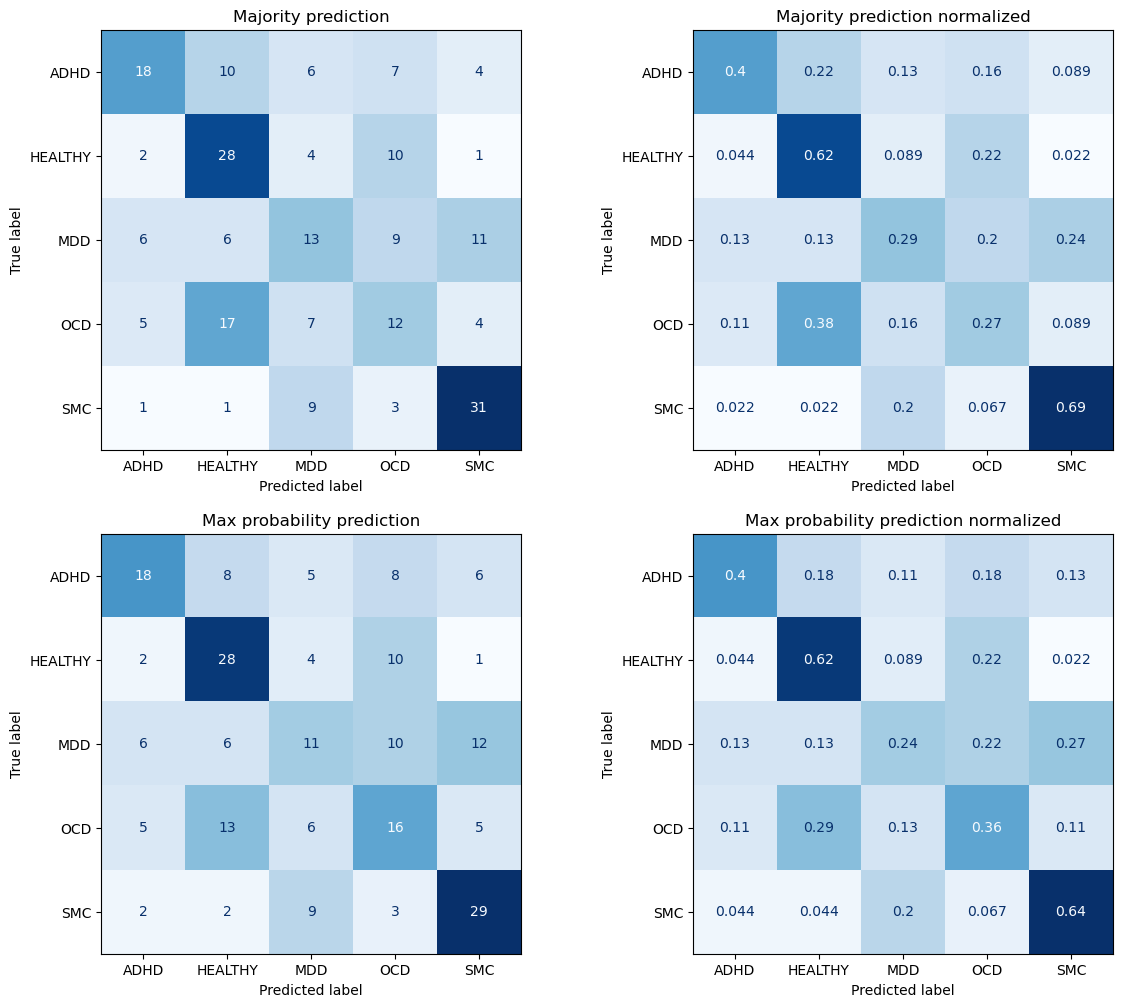

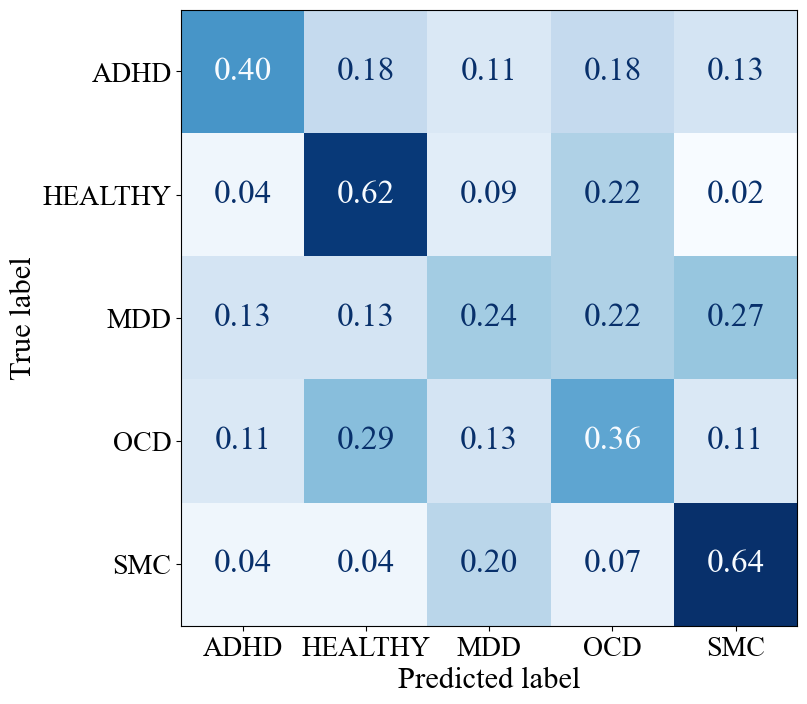

,participants_ID,prediction,proba_prediction,diagnosis
0,sub-87964717,MDD,MDD,SMC
1,sub-87965301,SMC,HEALTHY,SMC
2,sub-87966337,SMC,SMC,SMC
3,sub-87966473,OCD,OCD,SMC
4,sub-87966517,SMC,SMC,SMC
...,...,...,...,...
220,sub-88075593,OCD,OCD,ADHD
221,sub-88075817,MDD,MDD,MDD
222,sub-88076181,HEALTHY,OCD,OCD
223,sub-88076489,SMC,SMC,ADHD


In [6]:
pipeline_get_patient_predictions(
    condition='SSL',
    feature_file='df_fullytrained_acrossSub_ShallowNet_pretext_model_features.pkl',
    model_name='RF',
    log_model_name='nested_cv_RF_acrossSub',
    replication_feature_file=None,
    replication_set=False,
    test_run=False,
)

In [ ]:
best_params = {'learning_rate': 4.5889061600348155e-05, 'fc_layers': 3, 'optimizer': 'Adam', 'batch_size': 178, 'dropout': 0.06477113268225422}

df_replication_patient_predictions = pipeline_get_patient_predictions(
    condition='ShallowNet',
    feature_file='ShallowNet',
    model_name='ShallowNet',
    log_model_name='ShallowNet',
    replication_feature_file=None,
    replication_set=False,
    test_run=False,
    evaluate=True,
    best_params=best_params
)

No files found for participant ID sub-88073521
Loaded 2688 epochs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 178. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worke

#### Replication set

In [6]:
df_replication_patient_predictions = pipeline_get_patient_predictions(
    condition='SSL',
    feature_file='df_fullytrained_acrossSub_ShallowNet_pretext_model_features.pkl',
    model_name='RF',
    log_model_name='nested_cv_RF_acrossSub',
    replication_feature_file='df_replication_set_fullytrained_acrossSub_ShallowNet_pretext_model_features.pkl',
    replication_set=True,
    test_run=False,
    evaluate=False,
    condition_title='AcrossSub_RF'
)

<class 'pandas.core.frame.DataFrame'> (2700, 100)
(2700, 5)
df_replication_features.shape=(1440, 101)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'RF__n_estimators': 200, 'RF__min_samples_split': 10, 'RF__min_samples_leaf': 2, 'RF__max_features': 'log2', 'RF__max_depth': 90, 'RF__bootstrap': True}
Best score: 0.5320913499653758
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': True}


KeyboardInterrupt: 

### Handcrafted features GBC

#### Entire dataset

<class 'pandas.core.frame.DataFrame'> (2700, 320)
(2700, 5)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.5, 'gbc__n_estimators': 700, 'gbc__min_samples_split': 10, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.022013224311665046, 'gbc__criterion': 'friedman_mse'}
Best score: 0.505317108841731
{'subsample': 0.5, 'n_estimators': 700, 'min_samples_split': 10, 'loss': 'log_loss', 'learning_rate': 0.022013224311665046, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.3min finished


Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.60      0.56        45
     HEALTHY       0.53      0.56      0.54        45
         MDD       0.44      0.36      0.40        45
         OCD       0.41      0.42      0.42        45
         SMC       0.62      0.62      0.62        45

    accuracy                           0.51       225
   macro avg       0.51      0.51      0.51       225
weighted avg       0.51      0.51      0.51       225

f1_score: 0.5081689258138533

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.58      0.58      0.58        45
     HEALTHY       0.51      0.56      0.53        45
         MDD       0.47      0.40      0.43        45
         OCD       0.43      0.42      0.43        45
         SMC       0.61      0.67      0.64        45

    accuracy                           0.52       225
   macro avg      

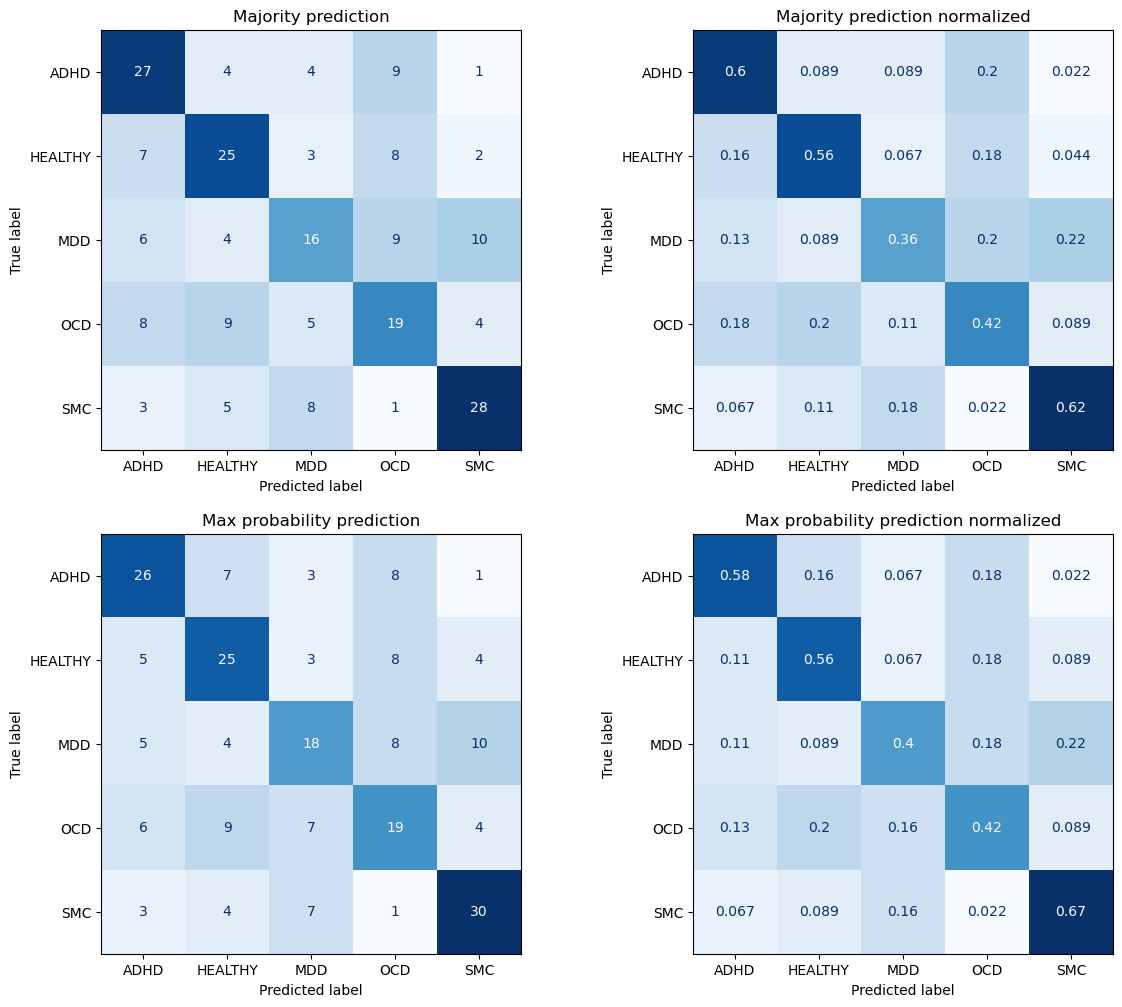

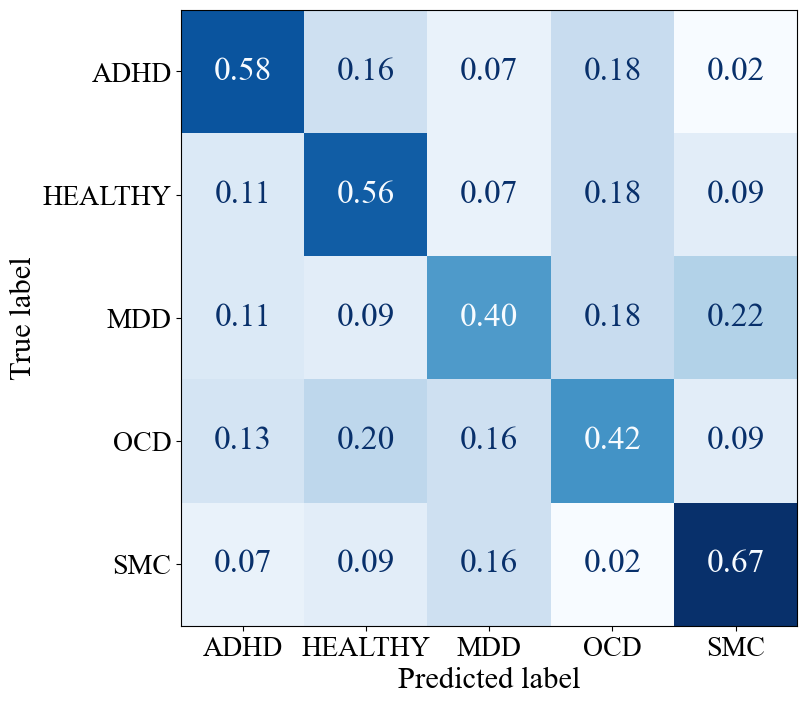

,participants_ID,prediction,proba_prediction,diagnosis
0,sub-87964717,SMC,SMC,SMC
1,sub-87965301,MDD,MDD,SMC
2,sub-87966337,SMC,SMC,SMC
3,sub-87966473,SMC,SMC,SMC
4,sub-87966517,MDD,MDD,SMC
...,...,...,...,...
220,sub-88075593,MDD,OCD,ADHD
221,sub-88075817,MDD,MDD,MDD
222,sub-88076181,OCD,OCD,OCD
223,sub-88076489,ADHD,HEALTHY,ADHD


In [7]:
pipeline_get_patient_predictions(
    condition='Handcrafted',
    feature_file='df_selected_stat_conn_features_ec.pkl',
    model_name='GBC',
    log_model_name='nested_cv_statconn_gbc_ec',
    replication_feature_file=None,
    replication_set=False,
    test_run=False,
)

#### Replication set

In [7]:
df_replication_patient_predictions = pipeline_get_patient_predictions(
    condition='Handcrafted',
    feature_file='df_selected_stat_conn_features_ec.pkl',
    model_name='GBC',
    log_model_name='nested_cv_statconn_gbc_ec',
    replication_feature_file='df_replication_selected_stat_conn_features_ec.pkl',
    replication_set=True,
    test_run=False,
    evaluate=False,
    condition_title='Handcrafted_GBC'
)

<class 'pandas.core.frame.DataFrame'> (2700, 320)
(2700, 5)
df_replication_features.shape=(1272, 321)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.5, 'gbc__n_estimators': 700, 'gbc__min_samples_split': 10, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.022013224311665046, 'gbc__criterion': 'friedman_mse'}
Best score: 0.505317108841731
{'subsample': 0.5, 'n_estimators': 700, 'min_samples_split': 10, 'loss': 'log_loss', 'learning_rate': 0.022013224311665046, 'criterion': 'friedman_mse'}
Unique IDs in replication set: 106
Replication template for Handcrafted_GBC saved successfully!


### Non-pretrained ShallowNet

#### Entire dataset

No files found for participant ID sub-88073521
Loaded 2688 epochs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 178. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worke

    participants_ID proba_prediction diagnosis
180    sub-87964717              SMC       SMC
0      sub-87965301              MDD       SMC
45     sub-87966337              SMC       SMC
90     sub-87966473              SMC       SMC
135    sub-87966517              SMC       SMC
Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.54      0.43      0.48        44
     HEALTHY       0.47      0.47      0.47        45
         MDD       0.32      0.31      0.31        45
         OCD       0.33      0.38      0.35        45
         SMC       0.69      0.76      0.72        45

    accuracy                           0.47       224
   macro avg       0.47      0.47      0.47       224
weighted avg       0.47      0.47      0.47       224

f1_score: 0.4679131777775604



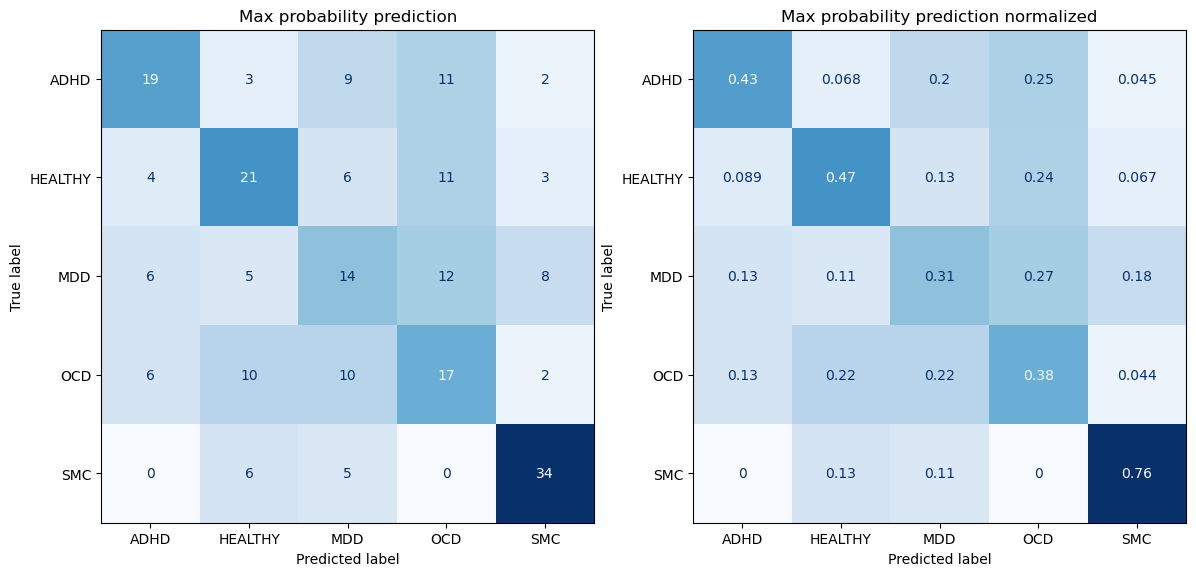

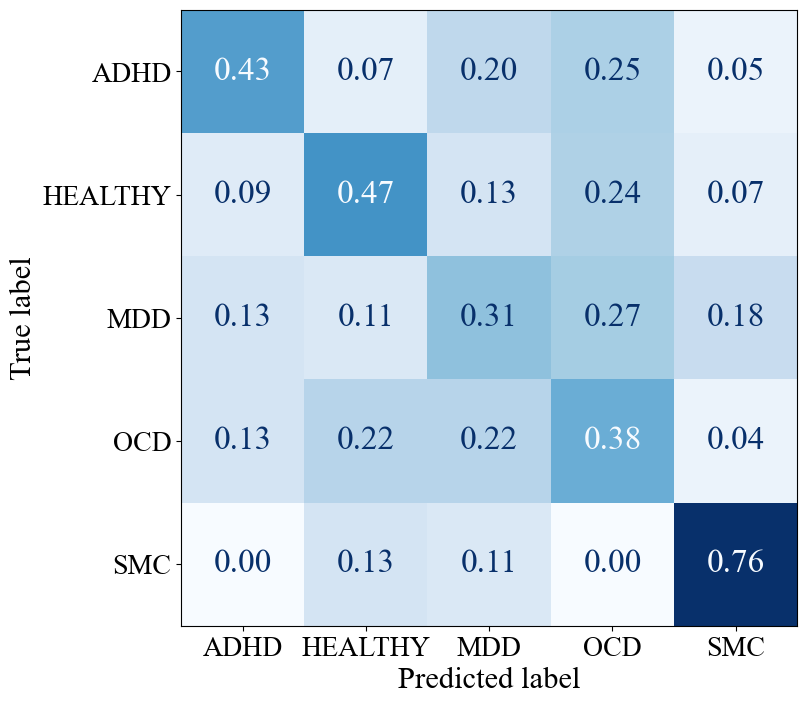

In [6]:
best_params = {'learning_rate': 4.5889061600348155e-05, 'fc_layers': 3, 'optimizer': 'Adam', 'batch_size': 178, 'dropout': 0.06477113268225422}

df_replication_patient_predictions = pipeline_get_patient_predictions(
    condition='ShallowNet',
    feature_file='ShallowNet',
    model_name='ShallowNet',
    log_model_name='ShallowNet',
    replication_feature_file=None,
    replication_set=False,
    test_run=False,
    evaluate=True,
    best_params=best_params
)

#### Replication set

In [6]:
best_params = {'learning_rate': 4.5889061600348155e-05, 'fc_layers': 3, 'optimizer': 'Adam', 'batch_size': 178, 'dropout': 0.06477113268225422}

df_replication_patient_predictions = pipeline_get_patient_predictions(
    condition='ShallowNet',
    feature_file='ShallowNet',
    model_name='ShallowNet',
    log_model_name='ShallowNet',
    replication_feature_file='ShallowNet',
    replication_set=True,
    test_run=False,
    evaluate=False,
    condition_title='nonpretrained_ShallowNet',
    best_params=best_params
)

No files found for participant ID sub-88073521
Loaded 2688 epochs
Loaded 1440 epochs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 178. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 18. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Y_proba.shape=torch.Size([1440, 5])
  participants_ID proba_prediction
0    sub-19681349              MDD
1    sub-19681385              MDD
2    sub-19684666              SMC
3    sub-19686324              SMC
4    sub-19687321              SMC
Replication template for nonpretrained_ShallowNet saved successfully!
